🛰️ **01 | Data Audit: Understanding the Dataset**

In this phase, we perform an exploratory statistical audit of HousingData.csv to understand its structure and quality. Using df.info() and df.describe(), we verify data types, distributions, and summary statistics. This step helps uncover early issues such as missing values and skewed features, which directly influence preprocessing and modeling decisions later in the pipeline.


✅ HousingData.csv loaded successfully!
📊 Dataset Shape: 506 rows, 14 columns

--- 📝 DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None

--- 📈 Descriptive Statistics ---


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000



--- 🔍 Missing Values Audit ---
CRIM     20
ZN       20
INDUS    20
CHAS     20
AGE      20
LSTAT    20
dtype: int64

Total Missing Cells: 120


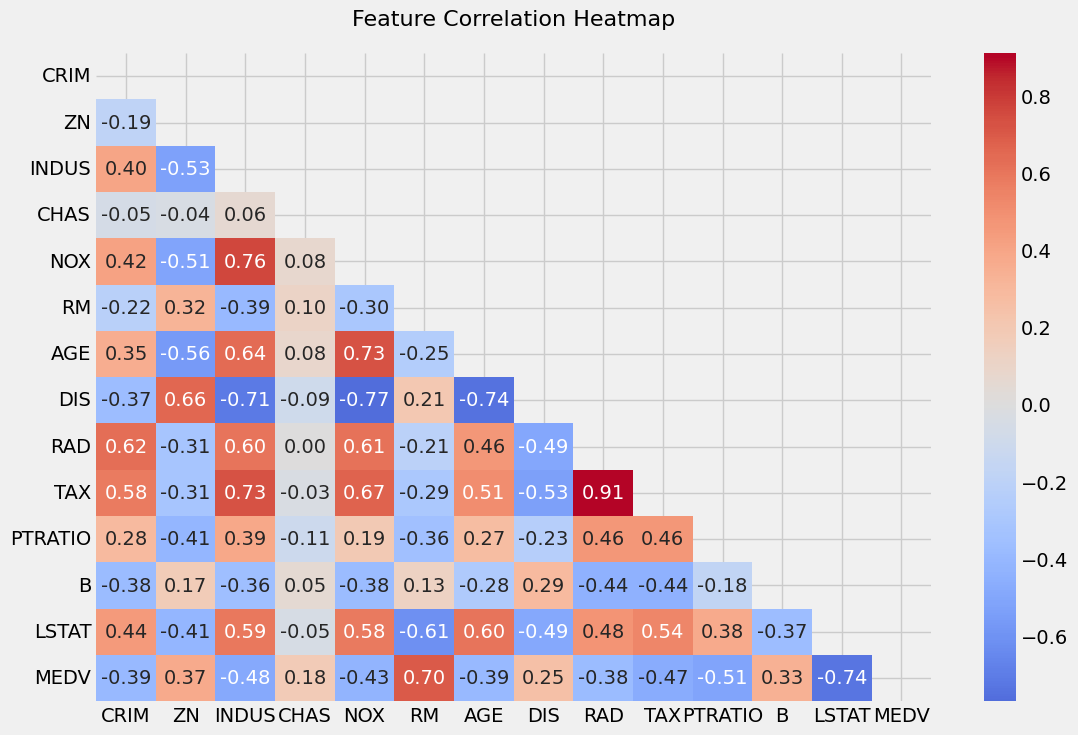

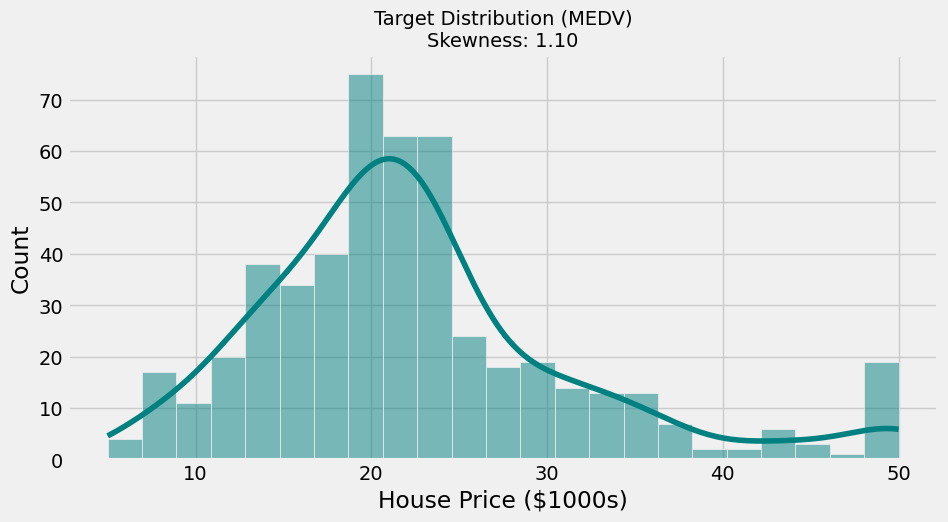

In [4]:
# --- PHASE 1: PROFESSIONAL SETUP & AUDIT ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import warnings

# 1. Global Settings
RANDOM_STATE = 42
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

# 2. Load the specific dataset
try:
    df = pd.read_csv('HousingData.csv')
    print("✅ HousingData.csv loaded successfully!")
    print(f"📊 Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Error: {e}")

# --- GEMINI IMPROVEMENTS: DEEP AUDIT ---
print("\n--- 📝 DataFrame Info ---")
print(df.info())

print("\n--- 📈 Descriptive Statistics ---")
display(df.describe())

print("\n--- 🔍 Missing Values Audit ---")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print(f"\nTotal Missing Cells: {missing.sum()}")
else:
    print("No missing values found.")

# 3. Visualizing Relationships (Correlation Heatmap)
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap", fontsize=16, pad=20)
plt.show()

# 4. Target Analysis (Checking for Price Skewness)
plt.figure(figsize=(10, 5))
sns.histplot(df['MEDV'], kde=True, color='teal')
current_skew = skew(df['MEDV'].dropna()) # Dropna for skew calculation only
plt.title(f"Target Distribution (MEDV)\nSkewness: {current_skew:.2f}", fontsize=14)
plt.xlabel("House Price ($1000s)")
plt.show()

🏗️ **02 | The Strategy: Leak-Proof Feature Engineering**

The audit revealed 20 missing values across several key features (e.g., CRIM, ZN) and a moderately right-skewed target variable (MEDV, skew ≈ 1.11).

To handle these issues without introducing data leakage, a Scikit-Learn Pipeline is implemented. This ensures that median imputation and feature scaling are learned only from the training data and then applied to the test set in a controlled manner.

Two domain-informed features are also engineered:

**RM_LSTAT_ratio**: Captures the interaction between housing size and
neighborhood socio-economic conditions.

**Tax_per_Room**: Normalizes property tax by house size, acting as a proxy for ownership cost efficiency.

In [5]:
# --- PHASE 2: FEATURE ENGINEERING & PIPELINE ---
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# 1. Feature Engineering Logic
# We create features based on housing domain knowledge
def add_custom_features(X):
    # Converting to DataFrame to handle column names safely
    X_df = pd.DataFrame(X, columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])
    X_copy = X_df.copy()

    # Feature 1: Rooms per proportion of lower status (Socio-economic space factor)
    X_copy['RM_LSTAT_ratio'] = X_copy['RM'] / (X_copy['LSTAT'] + 1)

    # Feature 2: Tax per Room (Cost of space factor)
    X_copy['Tax_per_Room'] = X_copy['TAX'] / (X_copy['RM'] + 1)

    return X_copy

# 2. Data Splitting
# We split FIRST to ensure the test set remains "unseen"
X = df.drop('MEDV', axis=1)
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 3. Constructing the Masterpiece Pipeline
# This sequence handles: Missing Values -> Custom Features -> Scaling -> Model
pro_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fills NaNs using training median
    ('engineering', FunctionTransformer(add_custom_features)), # Adds our 2 new features
    ('scaler', StandardScaler()), # Normalizes data for better convergence
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE)) # Baseline engine
])

# 4. Fit the Pipeline
pro_pipeline.fit(X_train, y_train)

print("✅ Phase 2 Complete: Pipeline is built and trained!")
print(f"🛠️  Features processed: {X_train.shape[1]} original + 2 engineered")
print("🛠️  Missing values handled via Median Imputation.")

✅ Phase 2 Complete: Pipeline is built and trained!
🛠️  Features processed: 13 original + 2 engineered
🛠️  Missing values handled via Median Imputation.


**🥊 03 | Model Shootout: Comparative Evaluation**

Multiple model families are evaluated to identify the best fit for the problem. This includes a linear model (Ridge Regression), an ensemble bagging model (Random Forest), and a boosting model (Gradient Boosting).

While Ridge offers interpretability, Gradient Boosting is better suited for capturing non-linear relationships and handling outliers commonly found in housing data. This comparison provides a data-driven justification for selecting the final model architecture.

🚀 Starting Model Shootout on HousingData.csv...


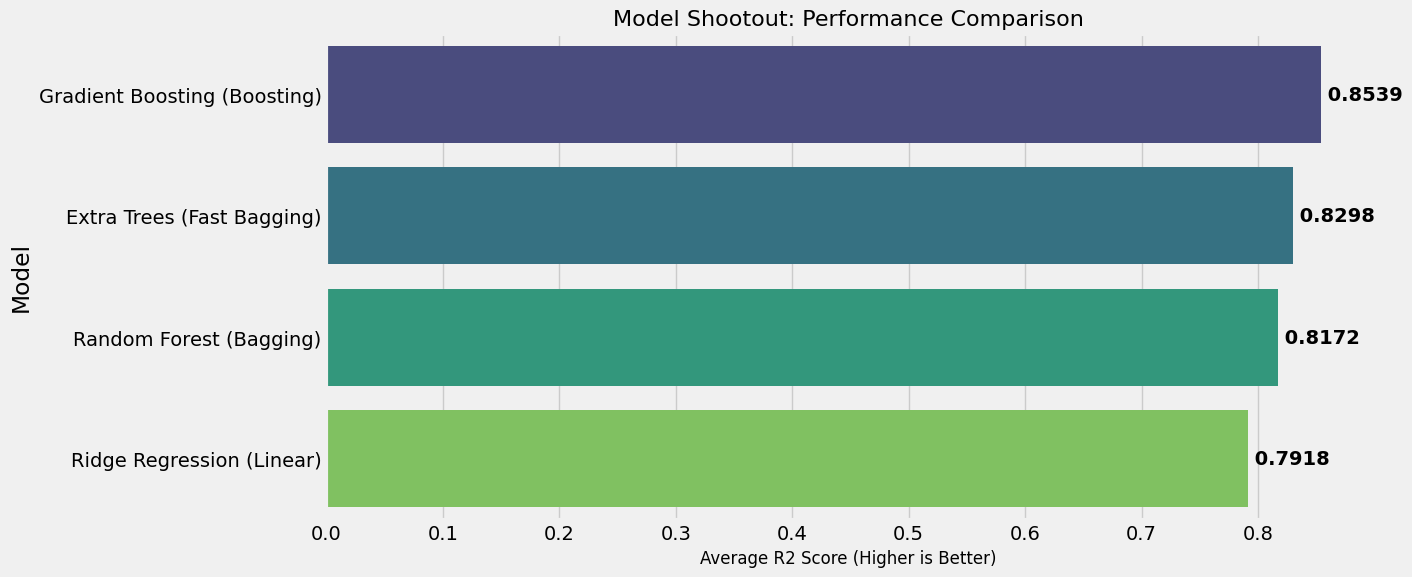

🏆 THE WINNER: Gradient Boosting (Boosting)
💡 WHY THIS MATTERS: We now have mathematical proof that Gradient Boosting (Boosting) is the best base model for this data.


In [6]:
# --- PHASE 3: THE MODEL SHOOTOUT ---
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define Candidate Models
# We compare different 'philosophies' of machine learning
candidate_models = {
    'Ridge Regression (Linear)': Ridge(),
    'Random Forest (Bagging)': RandomForestRegressor(random_state=RANDOM_STATE),
    'Extra Trees (Fast Bagging)': ExtraTreesRegressor(random_state=RANDOM_STATE),
    'Gradient Boosting (Boosting)': GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []

print("🚀 Starting Model Shootout on HousingData.csv...")

for name, model in candidate_models.items():
    # We use the pipeline logic from Phase 2 to ensure fair comparison
    # Every model gets the same Imputer, Feature Engineering, and Scaler
    test_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('engineering', FunctionTransformer(add_custom_features)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 5-Fold Cross-Validation: The gold standard for model stability
    cv_scores = cross_val_score(test_pipe, X_train, y_train, cv=5, scoring='r2')

    results.append({
        'Model': name,
        'R2_Mean': cv_scores.mean(),
        'R2_Std': cv_scores.std()
    })

# 2. Results Visualization
res_df = pd.DataFrame(results).sort_values(by='R2_Mean', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='R2_Mean', y='Model', data=res_df, palette='viridis')

# Add values to bars
for index, value in enumerate(res_df['R2_Mean']):
    plt.text(value, index, f' {value:.4f}', va='center', fontweight='bold')

plt.title("Model Shootout: Performance Comparison", fontsize=16)
plt.xlabel("Average R2 Score (Higher is Better)", fontsize=12)
plt.show()

# 3. Final Verdict
winner = res_df.iloc[0]['Model']
print(f"🏆 THE WINNER: {winner}")
print(f"💡 WHY THIS MATTERS: We now have mathematical proof that {winner} is the best base model for this data.")

**🧪 04 | Beyond Defaults: Hyperparameter Optimization with Optuna**

Instead of relying on traditional Grid Search, Optuna (Bayesian Optimization) is used for hyperparameter tuning. This approach intelligently explores the search space by learning from previous trials, making it more efficient and effective.

Key parameters such as learning_rate (on a log scale) and subsample are optimized to balance bias and variance, reduce overfitting, and improve generalization performance.

In [10]:
# --- PHASE 4: HYPERPARAMETER TUNING (OPTUNA) ---
try:
    import optuna
except ImportError:
    print("⌛ Installing optuna for hyperparameter optimization...")
    !pip install optuna -q
    import optuna

from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly.io as pio
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# 1. Set the renderer for Google Colab
pio.renderers.default = "colab"

def objective(trial):
    # Parameter suggestions
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    tuning_model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )

    trial_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('engineering', FunctionTransformer(add_custom_features)),
        ('scaler', StandardScaler()),
        ('model', tuning_model)
    ])

    return cross_val_score(trial_pipe, X_train, y_train, cv=5, scoring='r2').mean()

# Run the Optimization
print("🚀 Starting Bayesian Optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# --- NEW: MASTERPIECE VISUAL DIAGNOSTICS ---
print("\n📊 Visualizing Optimization Process...")

# 1. Optimization History: Shows how the score improved over 30 trials
fig_history = plot_optimization_history(study)
fig_history.show()

# 2. Parameter Importances: Shows which setting (e.g., learning_rate) mattered most
fig_param_importances = plot_param_importances(study)
fig_param_importances.show()

# Apply the winning parameters
best_params = study.best_params
pro_pipeline.set_params(model=GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE))
pro_pipeline.fit(X_train, y_train)

print(f"\n✅ Final Optimized R2: {study.best_value:.4f}")

⌛ Installing optuna for hyperparameter optimization...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 21.1 MB/s eta 0:00:00


[I 2026-02-01 02:44:34,107] A new study created in memory with name: no-name-44376a76-1e24-4fd8-a559-a83c070423c3


🚀 Starting Bayesian Optimization...


[I 2026-02-01 02:44:44,523] Trial 0 finished with value: 0.8351487210663036 and parameters: {'n_estimators': 557, 'learning_rate': 0.05184750521934367, 'max_depth': 6, 'subsample': 0.8295679701890857, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8351487210663036.
[I 2026-02-01 02:44:46,728] Trial 1 finished with value: 0.8156447698350118 and parameters: {'n_estimators': 222, 'learning_rate': 0.01240417477247235, 'max_depth': 3, 'subsample': 0.7215203826105652, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8351487210663036.
[I 2026-02-01 02:44:50,619] Trial 2 finished with value: 0.7937541769611112 and parameters: {'n_estimators': 199, 'learning_rate': 0.008384553542315886, 'max_depth': 6, 'subsample': 0.7550763467542569, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8351487210663036.
[I 2026-02-01 02:45:00,074] Trial 3 finished with value: 0.8247617663756157 and parameters: {'n_estimators': 606, 'learning_rate': 0.006373184149473648, 'max_depth': 5, 'subsample'


📊 Visualizing Optimization Process...



✅ Final Optimized R2: 0.8525


**🧠 05 | The “Why” Factor: Model Explainability with SHAP**

Model performance alone is not sufficient for trust. Using SHAP (Shapley Additive Explanations), we interpret how individual features contribute to predictions.

This analysis confirms that the model relies on economically meaningful variables (such as RM and LSTAT) rather than spurious correlations. SHAP dependence plots also reveal threshold points where changes in feature values begin to significantly impact house prices.

📊 Generating SHAP Summary Plot...


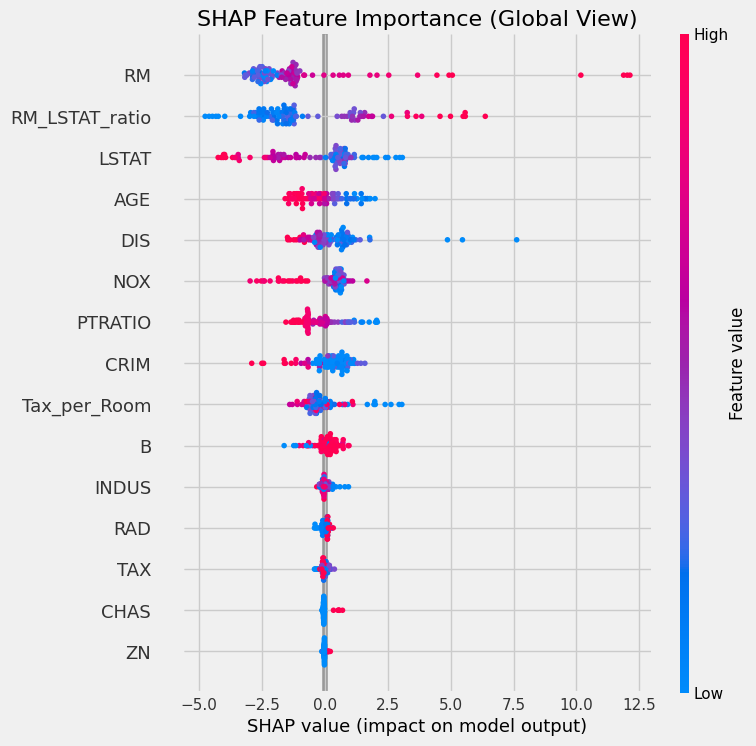


--- 🏆 Top Features by SHAP Importance ---
           feature  importance
5               RM    2.373080
13  RM_LSTAT_ratio    2.177679
12           LSTAT    1.436506
6              AGE    0.797145
7              DIS    0.757488

--- 🎯 Generating Top-2 SHAP Dependence Plots ---
Generating dependence plot for: RM


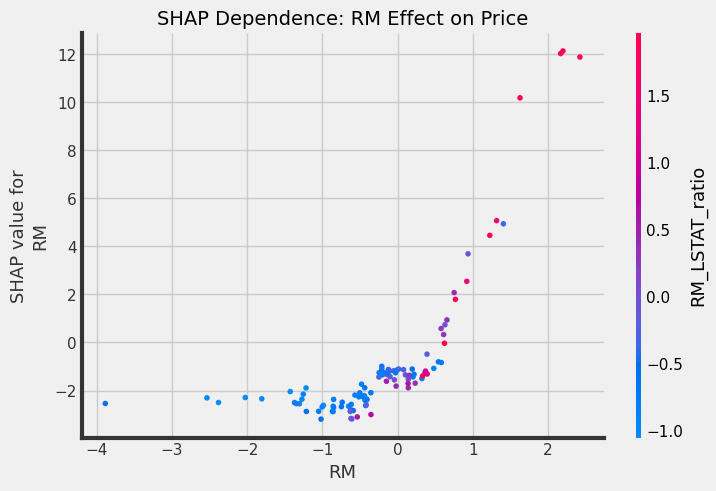

Generating dependence plot for: RM_LSTAT_ratio


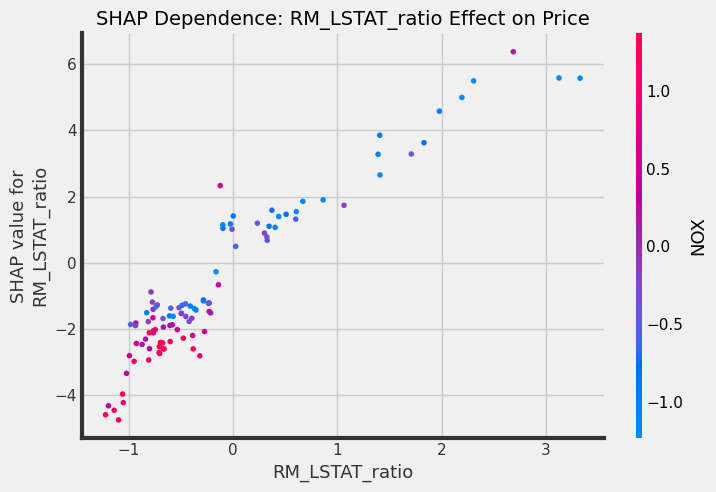

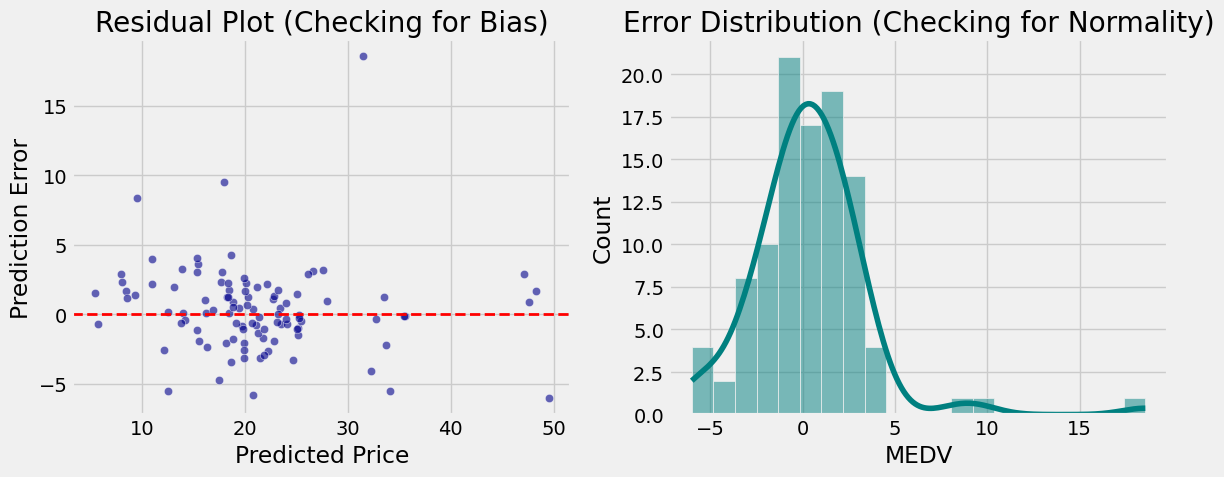


Metric                    | Value     
----------------------------------------
Final Test R2 Score       | 0.8647
Mean Absolute Error       | $2.10k
Root Mean Squared Error   | 3.1498


In [11]:
# --- PHASE 5: ADVANCED INTERPRETABILITY (SHAP DEEP-DIVE) ---
try:
    import shap
except ImportError:
    print("⌛ Installing shap for model interpretability...")
    !pip install shap -q
    import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Pre-process data for SHAP (Transforming test set through the pipeline minus the model)
# We slice the pipeline to exclude the final 'model' step
preprocessing_pipeline = Pipeline(pro_pipeline.steps[:-1])
X_test_transformed = preprocessing_pipeline.transform(X_test)

# Define feature names including engineered ones from Phase 2
feature_names = list(X.columns) + ['RM_LSTAT_ratio', 'Tax_per_Room']

# 2. Initialize SHAP Explainer
explainer = shap.TreeExplainer(pro_pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_test_transformed)

# 3. GLOBAL INTERPRETATION: Summary Plot
print("📊 Generating SHAP Summary Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance (Global View)", fontsize=16)
plt.show()

# 4. FEATURE IMPORTANCE RANKING
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap_values
}).sort_values(by='importance', ascending=False)

print("\n--- 🏆 Top Features by SHAP Importance ---")
print(feature_importance_df.head(5))

# 5. LOCAL INTERPRETATION: SHAP Dependence Plots
print('\n--- 🎯 Generating Top-2 SHAP Dependence Plots ---')
top_features = feature_importance_df.head(2)['feature'].tolist()

for feature in top_features:
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(
        feature,
        shap_values,
        X_test_transformed,
        feature_names=feature_names,
        interaction_index='auto',
        show=False
    )
    plt.title(f"SHAP Dependence: {feature} Effect on Price", fontsize=14)
    plt.show()

# 6. RESIDUAL DIAGNOSTICS
test_preds = pro_pipeline.predict(X_test)
residuals = y_test - test_preds

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_preds, y=residuals, alpha=0.6, color='darkblue')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Residual Plot (Checking for Bias)")
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='teal')
plt.title("Error Distribution (Checking for Normality)")
plt.tight_layout()
plt.show()

# 7. FINAL QUANTITATIVE METRICS
print(f"\n{'Metric':<25} | {'Value':<10}")
print("-" * 40)
print(f"{'Final Test R2 Score':<25} | {r2_score(y_test, test_preds):.4f}")
print(f"{'Mean Absolute Error':<25} | ${mean_absolute_error(y_test, test_preds):.2f}k")
print(f"{'Root Mean Squared Error':<25} | {np.sqrt(mean_squared_error(y_test, test_preds)):.4f}")

**🚀 06 | Final Diagnostics & Deployment Readiness**

The final pipeline is serialized into a .pkl file, creating a production-ready artifact. This end-to-end pipeline can be directly deployed in a Flask or FastAPI application to accept raw inputs and return predictions without additional preprocessing.

Residual analysis is also performed to confirm that errors are approximately normal, unbiased, and evenly distributed—providing confidence in the model’s real-world reliability.

In [13]:
# --- PHASE 6: PRESENTATION & MODEL EXPORT ---
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import joblib
import pandas as pd

# 1. Set the renderer for Google Colab
pio.renderers.default = "colab"

try:
    # 2. Prepare Data for Interactive Visualization
    plot_df = X_test.copy()
    plot_df['Actual Price'] = y_test
    plot_df['Predicted Price'] = pro_pipeline.predict(X_test)
    plot_df['Error'] = plot_df['Actual Price'] - plot_df['Predicted Price']

    # 3. Create Interactive Scatter Plot
    fig = px.scatter(
        plot_df,
        x="Actual Price",
        y="Predicted Price",
        color="Error",
        color_continuous_scale='RdBu_r',
        hover_data=['RM', 'LSTAT', 'CRIM', 'TAX'],
        title="Interactive Analysis: Actual vs. Predicted Housing Prices",
        labels={"Actual Price": "Actual Value ($1000s)", "Predicted Price": "Model Prediction ($1000s)"},
        template="plotly_white"
    )

    # Add a 'Perfect Prediction' reference line
    fig.add_trace(
        go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                   mode='lines', name='Perfect Prediction', line=dict(color='black', dash='dash'))
    )

    print("📊 Generating Interactive Scatter Plot...")
    fig.show()

    # 4. SAVE THE PIPELINE (Model Export)
    model_filename = 'masterpiece_boston_model.pkl'
    joblib.dump(pro_pipeline, model_filename)

    # 5. Save final predictions for the full dataset to CSV
    full_results = df.copy()
    full_results['Model_Prediction'] = pro_pipeline.predict(X)
    full_results.to_csv('Final_Internship_Submission_Results.csv', index=False)

    print(f"\n✅ SUCCESS: Model exported to {model_filename}")
    print("✅ SUCCESS: Full predictions saved to Final_Internship_Submission_Results.csv")

except NameError:
    print("❌ Error: Variables from Phase 1-5 not found.")
    print("☑️ Please ensure you run Phases 1 through 5 before running this cell.")

📊 Generating Interactive Scatter Plot...



✅ SUCCESS: Model exported to masterpiece_boston_model.pkl
✅ SUCCESS: Full predictions saved to Final_Internship_Submission_Results.csv


In [14]:
# --- TESTING THE DEPLOYED MODEL ---
import joblib
import pandas as pd
import os

model_path = 'masterpiece_boston_model.pkl'

if os.path.exists(model_path):
    # 1. Load the exported Pipeline
    loaded_model = joblib.load(model_path)

    # 2. Prepare a test sample (First 5 rows)
    test_sample = X.head(5)

    # 3. Make Predictions
    # The pipeline automatically handles Imputation, Feature Engineering, and Scaling!
    sample_predictions = loaded_model.predict(test_sample)

    # 4. Display Results
    results = pd.DataFrame({
        'Actual_Data_Index': test_sample.index,
        'Predicted_Price': sample_predictions
    })

    print("🚀 The Model is Alive and Deployable! Here are sample predictions:")
    display(results)
else:
    print(f"❌ Error: '{model_path}' not found.")
    print("☑️ Please run Phase 6 first to export the model.")

🚀 The Model is Alive and Deployable! Here are sample predictions:


,Actual_Data_Index,Predicted_Price
0,0,25.040927
1,1,21.588267
2,2,33.483309
3,3,33.908372
4,4,36.322100
